# Mogreps hyper-cube:

We will try make a cube that represents all of the mogreps-uk data (for one parameter: `surface_air_pressure`) for 2013. The data is stored on a public S3 bucket `mogreps-uk`. We have mounted that bucket using a FUSE file systems. The data is accessable via the filesystem path `/s3/mogreps-uk/`. We will use `surface_air_pressure` as some of the other parameters like `air_temperature` are more complicated/messy (see accompanying blog post).

Inspecting/knowlage of the data set reveals:

    Models run at 03 and 09

    Is a lagged ensamble:
    03 run has realisations/members 00 - 11
    09 run has realisations/members 00 and 12 - 22

    Forecast period:
    +0 to +36
    Split in to files with three one hour time steps per file except the first which has four one hour time steps.

In [1]:
import iris
import os
import warnings
from cf_units import Unit
from calendar import monthrange
from collections import namedtuple
import dask.array as da
import netCDF4
import numpy as np
from functools import reduce

BASE_PATH = '/s3/mogreps-uk/'

First we create our proxy class. This is an object that looks like a nd-array but deferes accessing the data until a calculation is requests.
Additionally our implementation will handle the case that the data or file doesn't exist or look as expected and return missing/fill data for that request.

In [2]:
# Based on `iris.fileformats.netcdf.NetCDFDataProxy - https://github.com/SciTools/iris/blob/v2.1.0/lib/iris/fileformats/netcdf.py#L374
class CheckingNetCDFDataProxy(object):
    """A reference to the data payload of a single NetCDF file variable."""

    def __init__(self, shape, dtype, path, variable_name, fill_value, do_safety_check=False):
        self.safety_check_done = do_safety_check
        self.shape = shape
        self.dtype = dtype
        self.path = path
        self.variable_name = variable_name
        self.fill_value = fill_value
        self.fatal_fail = None

    @property
    def ndim(self):
        return len(self.shape)

    def check(self):
        # This check runs one on first data access. If the check doesn't think the data in the file is that that was expected when the object was created
        # or the file is missing the check 'fails' and all future data request will return masked data.
        try:
            dataset = netCDF4.Dataset(self.path)
        except OSError:
            self.fatal_fail = "no such file %s" % self.path
            self.safety_check_done = True
            return
        
        try:
            variable = dataset.variables[self.variable_name]
        except KeyError:
            self.fatal_fail = "no variable %s in file %s" % (self.variable_name, self.path)
            self.safety_check_done = True
            return

        if list(variable.shape) != list(self.shape):
            self.fatal_fail = "Shape of data %s doesn't match expected %s" %(variable.shape, self.shape)
            self.safety_check_done = True
            return
        
        # TODO: check variable attributes/dims/etc? This check is very basic/simple further checking could be done but may come at a cost.
        
        self.safety_check_done = True
        
        
    def  _null_data(self, keys):
        # Return fill data in the correct shape
        
        null_data = np.ones(self.shape)[keys] * self.fill_value
        return null_data
        
    def __getitem__(self, keys):
        # Get some data. Do the safety check first and any issues return fill value data.
        
        if not self.safety_check_done:
            self.check()
            
        if self.fatal_fail:
            return self._null_data(keys)
            
        try:
            dataset = netCDF4.Dataset(self.path)
            variable = dataset.variables[self.variable_name]
            # Get the NetCDF variable data and slice.
            var = variable[keys]
        finally:
            if dataset:
                dataset.close()
        return np.asanyarray(var)

In [6]:
%%time
# This cell currently takes a couple of minutes on first run. It's not clear why.


VAR_NAME = 'surface_air_pressure'
grid_latitude_len = 548
grid_longitude_len = 421

# Given a year return all the model runs in that year as RunDate objects.
RunDate = namedtuple('RunDate',['year','month','day','hour'])
def runs(years):
    for year in years:
        for month in range(1,12):
            for day in range(1,monthrange(year,month)[1] +1):
                for hour in (3,9):
                    yield RunDate(year,month,day,hour)

def build_lazy_masked_array(shape, filepath, var):
    fill = 1e20
    proxy = CheckingNetCDFDataProxy(shape=shape,  dtype='float32', # TODO: Don't assuming float32?
                                path=filepath, variable_name=VAR_NAME,
                                fill_value = fill)
    lazy_array = da.from_array(proxy, shape)
    masked_array = da.ma.masked_equal(lazy_array, fill)
    return masked_array

def build_proxy_array_for_time_step(file_details):
    year, month, day, run_hr, realisation, time_step = file_details
    file_tpl = "/s3/mogreps-uk/prods_op_mogreps-uk_{year:d}{month:02d}{day:02d}_{run_hr:02d}_{realisation:02d}_{time_step:03d}.nc"
    grid_latitude_len = 548
    grid_longitude_len = 421
    
    num_steps_in_file = 4 if run_hr == 3 else 4 # First file in a run has an extra timestep
    forecast_periods = list(range(time_step, time_step+num_steps_in_file))
    filepath = file_tpl.format(year=year, month=month, day=day, run_hr=run_hr, realisation=realisation, time_step=time_step)

    # This is the shape our fundemental chunks i.e. the data inside our files. 
    shape=(len(forecast_periods), grid_latitude_len, grid_longitude_len)

    return build_lazy_masked_array(shape, filepath, VAR_NAME)

def build_data_array():
    # Build a lazy nd-array that will underpin our hyper-cube
    # Shape will be (realisations, runs, timesteps, lat, lon)
    # We loop through these dimensions from outside in until we get to our bottom fundemental chunk, a file in this case.
    
    file_tpl = "/s3/mogreps-uk/prods_op_mogreps-uk_{year:d}{month:02d}{day:02d}_{run:02d}_{realisation:02d}_{step:03d}.nc"
    realisations = range(0,22+1)
    
    realisation_collection = [] # each loop collects the data arrays from each iteration so that they can be joined when the loop closes/completes 
    for realisation in realisations:
        
        runs_collection = []
        for year, month, day, run in runs(2013):
            
#             timestep_collection = []
            
            
            files_in_run = ((year, month, day, run, realisation, step) for step in range(3,36+1,3))
#             rd = map(build_proxy_array_for_time_step, files_in_run)
#             print(rd)
#             assert  1== 2
            run_data = da.concatenate(list(map(build_proxy_array_for_time_step, files_in_run)), 0)
            
            runs_collection.append(run_data)
#             for step in range(3,36+1,3):
#                 # Inside our most loop we build our proxy's for our fundemental chunks, a single file. 
                
                
                
#                 ref_time = (year,month,day,run)
#                 forecast_periods = list(range(step,step+3))
#                 if step == 3:
#                     forecast_periods = list(range(step,step+4)) # First file in a run has an extra timestep

#                 filepath = file_tpl.format(year=year, month=month, day=day, run=run, realisation=realisation, step=step)

#                 # This is the shape our fundemental chunks / the data inside our files. 
#                 # The lazy array needs to know it's shape without reading anyfiles. So we tell it.
#                 shape=(len(forecast_periods), grid_latitude_len, grid_longitude_len)

#                 proxy = build_lazy_masked_array(shape, filepath, VAR_NAME)
#                 timestep_collection.append(proxy)

            # As we exit each inner loop we join the collected lazy arrays in to one array either by concatinating along an existing dimension
            # Or but `stacking` to create a new dimension
#             run_data = da.concatenate(timestep_collection,0) 
#             runs_collection.append(run_data)
                
    
        realisation_data = da.stack(runs_collection, 0)
        realisation_collection.append(realisation_data)
    
    return da.stack(realisation_collection, 0)
                    
data = build_data_array()
data

CPU times: user 1min 44s, sys: 1.05 s, total: 1min 46s
Wall time: 1min 45s


In [7]:
data

dask.array<stack, shape=(23, 668, 48, 548, 421), dtype=float32, chunksize=(1, 1, 4, 548, 421)>

In [4]:
# def build_proxy_array_for_time_step(file_details):
#     year, month, day, run_hr, realisation, time_step = file_details
#     file_tpl = "/s3/mogreps-uk/prods_op_mogreps-uk_{year:d}{month:02d}{day:02d}_{run_hr:02d}_{realisation:02d}_{time_step:03d}.nc"
#     grid_latitude_len = 548
#     grid_longitude_len = 421
    
#     num_steps_in_file = 4 if step == 3 else 4 # First file in a run has an extra timestep
#     forecast_periods = list(range(time_step, time_step+num_steps_in_file))
#     filepath = file_tpl.format(year=year, month=month, day=day, run_hr=run_hr, realisation=realisation, time_step=time_step)

#     # This is the shape our fundemental chunks i.e. the data inside our files. 
#     shape=(len(forecast_periods), grid_latitude_len, grid_longitude_len)

#     return build_lazy_masked_array(shape, filepath, VAR_NAME)


# da.concatenate(map(build_proxy_array_for_time_step, file_details for time_step in range(3,36+1,3) )

SyntaxError: unexpected EOF while parsing (<ipython-input-4-e6f59b84ae1a>, line 17)

We now have our data array. We can start accessing an processing the data immediately if we wished however it's useful to wrap it in a higher order object like an Iris Cube to allow higer order and geospacial aware functions.

In [9]:
# Build a cube from our data array

# Given a list of points and a name create a Iris DimCoord
def points_to_coord(var_name, points, units=None, long_name=None, standard_name=None):
    long_name = long_name if long_name else var_name
    return iris.coords.DimCoord(
        points=points,
        standard_name=standard_name,
        long_name=long_name if long_name else var_name,
        var_name=var_name, units=units)

# Here we cheat a little rather, than defining the lat and lon coord by hand I chose one file to represent them all and just read the coord info from that.
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sample_cube = iris.load(os.path.join(BASE_PATH, "prods_op_mogreps-uk_20130101_03_00_027.nc"), VAR_NAME)[0]


coords = [
    points_to_coord('realisation', list(range(data.shape[0]))),
    points_to_coord('forecast_refrance_time', list(range(3, data.shape[1]*12, 12)), units=Unit('hours since 2013-01-01', calendar='gregorian')),
    points_to_coord('forecast_period', list(range(0,data.shape[2])), units=Unit('hours')),
    sample_cube.coord('grid_latitude'),
    sample_cube.coord('grid_longitude')
]

cube = iris.cube.Cube(
        data=data,
        standard_name=VAR_NAME,
        long_name=VAR_NAME,
        var_name=VAR_NAME,
        units = Unit('Pa'),
        dim_coords_and_dims=[(coord, i)for i, coord in enumerate(coords)])

print(cube)

surface_air_pressure / (Pa)         (realisation: 23; forecast_refrance_time: 668; forecast_period: 48; grid_latitude: 548; grid_longitude: 421)
     Dimension coordinates:
          realisation                           x                           -                     -                  -                    -
          forecast_refrance_time                -                           x                     -                  -                    -
          forecast_period                       -                           -                     x                  -                    -
          grid_latitude                         -                           -                     -                  x                    -
          grid_longitude                        -                           -                     -                  -                    x


In [11]:
# Access some data
cube[:,1,2,10,:].data

masked_array(
  data=[[101867.25, 101864.625, 101861.875, ..., 100561.625, 100526.75,
         100344.125],
        [101908.75, 101906.25, 101903.625, ..., 100551.125, 100514.375,
         100330.875],
        [101959.875, 101957.625, 101955.125, ..., 100550.375, 100515.375,
         100333.125],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [12]:
def human_bytes(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def estimate_cube_size(cube):
    import functools
    import operator
    num_points = functools.reduce(operator.mul, cube.shape, 1)
    return human_bytes((num_points * 32) / 8)

# An estimates cubesize, not accurate but an intresting metric to gague size
estimate_cube_size(data)

'633.8GiB'

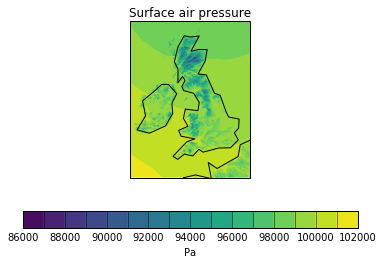

In [13]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import iris
import iris.plot as iplt
import iris.quickplot as qplt


qplt.contourf(cube[0,0,0,:,:], 15, cmap='viridis')
plt.gca().coastlines()
